In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import time

import elfi


In [2]:
from functools import partial

import numpy as np

import elfi


def MA1(t1, n_obs=100, batch_size=1, random_state=None):
    r"""Generate a sequence of samples from the MA1 model.

    The sequence is a moving average

        x_i = w_i + \theta_1 w_{i-1}

    where w_i are white noise ~ N(0,1).

    Parameters
    ----------
    t1 : float, array_like
    n_obs : int, optional
    batch_size : int, optional
    random_state : RandomState, optional

    """
    # Make inputs 2d arrays for broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))

    random_state = random_state or np.random

    # i.i.d. sequence ~ N(0,1)
    w = random_state.randn(batch_size, n_obs + 2)
    x = w[:, 2:] + t1 * w[:, 1:-1]
    return x.reshape((batch_size, -1))  # ensure 2D


def stochastic_volatility(w=-0.736,
                          rho=0.9,
                          sigma_v=0.36,
                          n_obs=100,
                          batch_size=1,
                          random_state=None):
    """Sample for a stochastic volatility model.

    specified in Frazier and Drovandi (2021). This is the true Data
    Generating Process for this example.
    Uses a normally distributed shock term.

    Parameters
    ----------
    w : float, optional
    rho : float, optional
    sigma_v : float, optional
    n_obs : int, optional
    batch_size : int, optional
    random_state : RandomState, optional

    Returns
    -------
    y_mat : np.array

    """
    random_state = random_state or np.random

    h_mat = np.zeros((batch_size, n_obs))
    y_mat = np.zeros((batch_size, n_obs))

    w_vec = np.repeat(w, batch_size)
    rho_vec = np.repeat(rho, batch_size)
    sigma_v_vec = np.repeat(sigma_v, batch_size)

    h_mat[:, 0] = w_vec + random_state.normal(0, 1, batch_size) * sigma_v_vec
    y_mat[:, 0] = np.exp(h_mat[:, 0]/2) * random_state.normal(0, 1, batch_size)

    for i in range(n_obs - 1):
        h_mat[:, i] = w_vec + rho_vec * h_mat[:, i-1] + \
            random_state.normal(0, 1, batch_size) * sigma_v_vec
        y_mat[:, i] = np.exp(h_mat[:, i]/2)*random_state.normal(0, 1, batch_size)

    return y_mat.reshape((batch_size, -1))  # ensure 2d


def autocov(x, lag=0):
    """Return the autocovariance.

    Assumes a (weak) univariate stationary process with mean 0.
    Realizations are in rows.

    Parameters
    ----------
    x : np.array of size (n, m)
    lag : int, optional

    Returns
    -------
    C : np.array of size (n,)

    """
    x = np.atleast_2d(x)
    # In R this is normalized with x.shape[1]
    if lag == 0:
        C = np.mean(x[:, :] ** 2, axis=1)
    else:
        C = np.mean(x[:, lag:] * x[:, :-lag], axis=1)

    return C


def get_model(n_obs=50, true_params=None, seed_obs=None):
    """Return a complete misspecified MA1 model in inference task.

    Parameters
    ----------
    n_obs : int, optional
        observation length of the MA2 process
    true_params : list, optional
        parameters with which the observed data is generated
    seed_obs : int, optional
        seed for the observed data generation

    Returns
    -------
    m : elfi.ElfiModel

    """
    if true_params is None:
        true_params = [-0.736, 0.9, 0.36]

    y = stochastic_volatility(*true_params, n_obs=n_obs,
                              random_state=np.random.RandomState(seed_obs))
    sim_fn = partial(MA1, n_obs=n_obs)

    m = elfi.ElfiModel()
    elfi.Prior('uniform', -1, 2, model=m, name='t1')
    elfi.Simulator(sim_fn, m['t1'], observed=y, name='MA1')
    elfi.Summary(autocov, m['MA1'], name='S1')
    elfi.Summary(autocov, m['MA1'], 1, name='S2')

    return m

In [3]:
from elfi.methods.bsl import pre_sample_methods, pdf_methods


In [4]:
from mm_sbi_review.examples.misspec_ma1 import assumed_dgp, calculate_summary_statistics, true_dgp

In [5]:
import jax.random as random

In [6]:
# feature_names = ['S1', 'S2']
# params = {'t1': 0.0}

# nsim = 10000
# m = get_model(n_obs=100, seed_obs=0)
# seed = 1
# pre_sample_methods.plot_features(m, params, nsim, feature_names, seed=seed)

# likelihood = pdf_methods.robust_likelihood('mean')

# nsim = [100, 300, 500]
# std_value = pre_sample_methods.log_SL_stdev(m, params, nsim, feature_names,
#                                             likelihood=likelihood, M=100, seed=seed)
# std_value


Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete


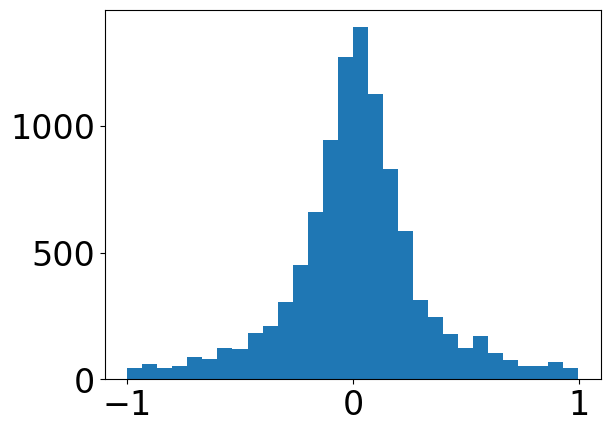

In [7]:
np.random.seed(123)

# true_params = [1]
feature_names = ['S1', 'S2']

# true_params = [-0.736, 0.9, 0.36]

batch_size = 50
mcmc_iters = 11000
burn_in = 1000
num_runs = 1
num_params = 1

res_mat_sbsl = np.zeros((mcmc_iters - burn_in, num_params, num_runs))
res_mat_rbslm = np.zeros((mcmc_iters - burn_in, num_params, num_runs))
res_mat_rbslv = np.zeros((mcmc_iters - burn_in, num_params, num_runs))

for i in range(num_runs):
    # tic = time.time()
    seed = i
    m = get_model(n_obs=100, seed_obs=i)
    seed = 0
    rng_key = random.PRNGKey(seed)
    rng_key, sub_key = random.split(rng_key)
    x_obs = true_dgp(key=sub_key, n_obs=100)
    m.observed['MA1'] = np.array(x_obs)
    # d = elfi.SyntheticLikelihood("bsl", m['S1'], m['S2'], name="SL")
    # sbsl_batch_size = 500
    # bsl_res = elfi.BSL(
    #             m['SL'],
    #             batch_size=sbsl_batch_size,
    #             ).sample(
    #                 mcmc_iters,
    #                 burn_in=burn_in,
    #                 sigma_proposals=0.1*np.eye(1),
    #                 params0=[0]
    #             )
    # # print('bsl_res', bsl_res)
    # elfi.SyntheticLikelihood("rbsl", m['S1'], m['S2'],
    #                             adjustment="mean", name="R_BSL_M")
    # # bsl_res.plot_marginals(bins=30)
    # res_mat_sbsl[:, 0, i] = bsl_res.outputs['t1']

    likelihood = pdf_methods.robust_likelihood('mean')
    nsim_round = 50
    rbsl_m = elfi.BSL(m, nsim_round, feature_names=feature_names,
                      likelihood=likelihood, seed=seed)
    params0 = np.array([0])
    est_post_cov = 0.01*np.eye(1)
    # logit_transform_bound = [(-1, 1)]
    res_m = rbsl_m.sample(mcmc_iters, est_post_cov, burn_in=burn_in,
                        params0=params0, tau=1.0)

    res_mat_rbslm[:, 0, i] = res_m.outputs['t1']


    likelihood = pdf_methods.robust_likelihood('variance')
    rbsl_v = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)
    res_v = rbsl_v.sample(mcmc_iters, est_post_cov, burn_in=burn_in,
                        params0=params0, tau=1.0)

    res_mat_rbslv[:, 0, i] = res_v.outputs['t1']
    # ess = bsl_res_misspec_var.compute_ess()
    # print('ess: ', ess)
    # bsl_res_misspec_var.plot_traces()
    # plt.savefig("plot_traces_misspec.png")
    # bsl_res_misspec_var.plot_marginals()
    # plt.savefig("plot_marginals_misspec.png")
    # bsl_res_misspec_var.plot_pairs()
    # plt.savefig("plot_pairs_misspec.png")
    # res_mat_rbslv[:, 0, i] = bsl_res_misspec_var.outputs['t1']

# plt.savefig("plot_marginals_standard_contaminated.png")

plt.rcParams.update({'font.size': 24})

# plot R-BSL-M
t1_samples_rbslm = res_mat_rbslm.flatten()
plt.hist(t1_samples_rbslm, bins=30)
plt.savefig("plot_marginals_contaminated_ma1_rbslm.pdf")
plt.clf()

# plot R-BSL-V
t1_samples_rbslv = res_mat_rbslv.flatten()
plt.hist(t1_samples_rbslv, bins=30)
plt.savefig("plot_marginals_contaminated_ma1_rbslv.pdf")

np.save("ma1_misspec_rbslm.npy", t1_samples_rbslm)
np.save("ma1_misspec_rbslv.npy", t1_samples_rbslv)

# plt.show()    


In [8]:
res_m

Method: BSL
Number of samples: 10000
Number of simulations: 544300
MCMC Acceptance Rate: 0.499
Parameter                Mean               2.5%              97.5%
t1:                     0.036             -0.783              0.871


In [9]:
res_v

Method: BSL
Number of samples: 10000
Number of simulations: 546700
MCMC Acceptance Rate: 0.698
Parameter                Mean               2.5%              97.5%
t1:                     0.013             -0.699              0.710


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import elfi.visualization.visualization

# Define the number of bins
mbins = 30

# Extract gamma values from the results
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_m.observed.size)], np.transpose(res_m.outputs['gamma'])))

# Set global font size
plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 18,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})

# Plot the marginal distributions
for i, (key, values) in enumerate(gamma_dict.items()):
    plt.figure(figsize=(8, 6))
    
    # Plot the posterior distribution as a histogram
    plt.hist(values, bins=mbins, density=True, alpha=0.8, color='black', label='Posterior')
    
    # Plot the prior distribution (Laplace(0, 1))
    x = np.linspace(-10, 10, 1000)
    prior = stats.laplace.pdf(x, loc=0, scale=1)
    plt.plot(x, prior, 'green', linestyle='dashed', lw=3, label='Prior')
    
    plt.xlim([-10, 10])
    plt.xticks([-10, -5, 0, 5, 10])
    plt.xlabel(r"$\gamma_{}$".format(str(i+1)))
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"rbslm_adj_param_{str(i)}.pdf")
    plt.clf()

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import elfi.visualization.visualization

plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 18,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})


# Define the number of bins
mbins = 30

# Extract gamma values from the results
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_v.observed.size)], np.transpose(res_v.outputs['gamma'])))

# Set global font size
plt.rcParams.update({'font.size': 24})

# Plot the marginal distributions
for i, (key, values) in enumerate(gamma_dict.items()):
    plt.figure(figsize=(8, 6))
    
    # Plot the posterior distribution as a histogram
    plt.hist(values, bins=mbins, density=True, alpha=0.8, color='black', label='Posterior')
    
    # Plot the prior distribution (Laplace(0, 1))
    x = np.linspace(0, 10, 1000)
    prior = stats.expon.pdf(x, loc=0, scale=1)
    plt.plot(x, prior, 'green', linestyle='dashed', lw=3, label='Prior')
    
    plt.xlim([0, 10])
    plt.xticks([0, 5, 10])
    plt.xlabel(r"$\gamma_{}$".format(str(i+1)))
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"rbslv_adj_param_{str(i)}.pdf")
    plt.clf()

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

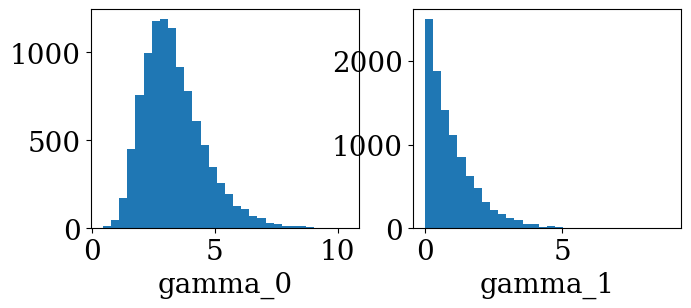

In [12]:
mbins = 30
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_v.observed.size)], np.transpose(res_v.outputs['gamma'])))
elfi.visualization.visualization.plot_marginals(gamma_dict, bins=mbins);

In [33]:

plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 15,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})
# plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(t1_samples_rbslm, bins=30, color='orange', alpha=0.75)  # Histogram with 30 bins
plt.xlabel(r'$\theta$')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
# plt.title("RBSL-M", fontsize=24)  # Title
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Enable grid with custom settings
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=2, label='Pseudo-true θ')  # Mean line
# plt.text(np.mean(samples), plt.ylim()[1] * 0.9, 'Mean: {:.2f}'.format(np.mean(samples)), color='red', horizontalalignment='right')  # Text label for mean
# plt.legend(loc='upper left')  # Add legend
plt.xlim([-1, 1])  # Set x-axis limits
plt.xticks([-1, - 0, 1])  # Set x-axis ticks
plt.yticks([0, 500, 1000])  # Set y-axis ticks
plt.tight_layout()  # Tight layout

plt.savefig("rbslm.pdf")  # Save the figure as a PDF
plt.clf()  # Clear the figure after saving



<Figure size 640x480 with 0 Axes>

In [28]:
plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 18,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})

# plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(t1_samples_rbslv, bins=30, color='green', alpha=0.75)  # Histogram with 30 bins
plt.xlabel(r'$\theta$')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
# plt.title("RBSL-V", fontsize=24)  # Title
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Enable grid with custom settings
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=2, label='Pseudo-true θ')  # Mean line
# plt.text(np.mean(samples), plt.ylim()[1] * 0.9, 'Mean: {:.2f}'.format(np.mean(samples)), color='red', horizontalalignment='right')  # Text label for mean
# plt.legend(fontsize=24)  # Add legend
plt.xlim([-1, 1])  # Set x-axis limits
plt.xticks([-1, - 0, 1])  # Set x-axis ticks
plt.yticks([0, 750, 1500])  # Set y-axis ticks
plt.tight_layout()  # Tight layout
plt.savefig("rbslv.pdf")  # Save the figure as a PDF
plt.clf()  # Clear the figure after saving



<Figure size 640x480 with 0 Axes>

In [15]:
import pickle as pkl
with open("thetas.pkl", "rb") as f:
    rsnl_thetas = pkl.load(f)

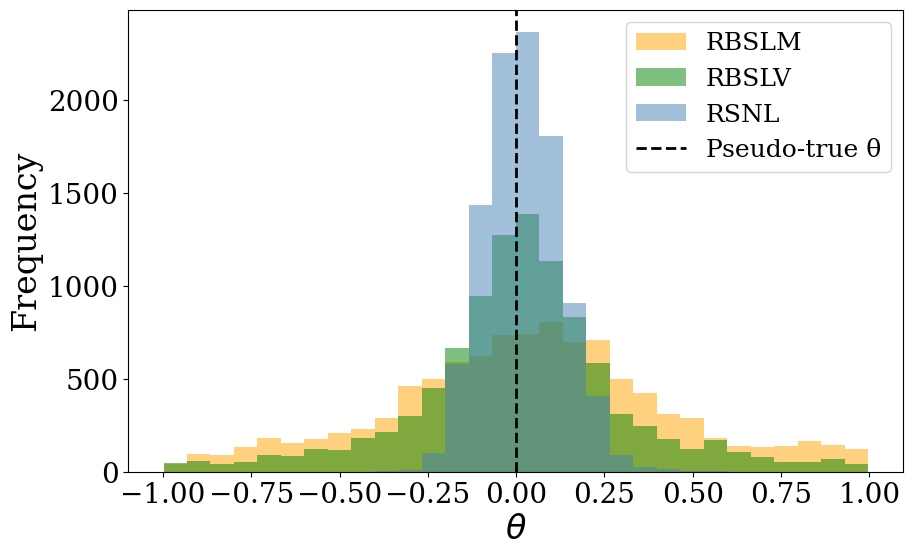

In [16]:
plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 18,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})
plt.figure(figsize=(10, 6))  # Set the figure size for better readability


# Plot RBSLM
_, bins, _ = plt.hist(t1_samples_rbslm, bins=30, color='orange', alpha=0.5, label='RBSLM')

# Plot RBSLV
plt.hist(t1_samples_rbslv, bins=bins, color='green', alpha=0.5, label='RBSLV')

# Plot RSNL
plt.hist(rsnl_thetas, bins=bins, color='steelblue', alpha=0.5, label='RSNL')


plt.xlabel(r'$\theta$', fontsize=24)  # X-axis label
plt.ylabel('Frequency', fontsize=24)  # Y-axis label
# plt.title("Comparison of RSNL, RBSLM, and RBSLV", fontsize=24)  # Title
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=2, label='Pseudo-true θ')  # Mean line
plt.legend(fontsize=18)  # Add legend
plt.savefig("comparison_histogram.pdf")  # Save the figure as a PDF
plt.show()  # Show the plot

In [35]:
posterior_samples = t1_samples_rbslm

sim_fn = partial(MA1, n_obs=100)

plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 18,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})

# Posterior predictive simulations
def b_theta(t):
    return np.array([1 + t ** 2, t])

t_vals = np.linspace(-1, 1, 101)
b_theta_vals = np.array([b_theta(t) for t in t_vals])
# Plot the histogram of posterior samples
# plt.figure(figsize=(8, 6))
# plt.hist(posterior_samples, bins=50, density=True, alpha=0.6, color='blue', label='Posterior Samples')

# Plot the prior distribution for comparison
theta_range = np.linspace(-1, 1, 200)

num_posterior_samples = len(posterior_samples)
num_pp_samples = 2_000  # Number of posterior predictive samples

# Initialize array to store summary statistics
posterior_pred_sims = np.empty((num_pp_samples, 2))

# Perform posterior predictive simulations
for i in range(num_pp_samples):
    # key, subkey = random.split(key)
    t1 = posterior_samples[i]
    y = sim_fn(t1)
    posterior_pred_sims[i, 0] = autocov(y, lag=0)
    posterior_pred_sims[i, 1] = autocov(y, lag=1)

# Plot the joint distribution of summary statistics from posterior predictive simulations
# plt.figure(figsize=(8, 6))
plt.scatter(posterior_pred_sims[:, 1], posterior_pred_sims[:, 0], c='blue', alpha=0.1)

# Plot the observed summary statistics
plt.scatter(autocov(x_obs, 1),autocov(x_obs, 0), c='black', marker='x', s=100, label=r'$S(\mathbf{y})$')

# Plot the b_theta function for reference
plt.plot(b_theta_vals[:, 1], b_theta_vals[:, 0], color='orange', label=r'$b(\theta)$', linewidth=4)

# Set axis limits and labels
plt.xlim(-2.0, 2.0)
plt.xticks([-2, 0, 2])
plt.ylim(-0.5, 2.5)
plt.yticks([-0.5, 1, 2.5])
plt.xlabel(r'$\zeta_1$')
plt.ylabel(r'$\zeta_2$')
# plt.title('Posterior Predictive Summary Statistics')
plt.legend()
plt.tight_layout()
plt.savefig("figs/rbslm_ppc.pdf")
plt.clf()


<Figure size 640x480 with 0 Axes>

In [36]:
posterior_samples = t1_samples_rbslv

sim_fn = partial(MA1, n_obs=100)

plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 18,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})

# Posterior predictive simulations
def b_theta(t):
    return np.array([1 + t ** 2, t])

t_vals = np.linspace(-1, 1, 101)
b_theta_vals = np.array([b_theta(t) for t in t_vals])
# Plot the histogram of posterior samples
# plt.figure(figsize=(8, 6))
# plt.hist(posterior_samples, bins=50, density=True, alpha=0.6, color='blue', label='Posterior Samples')

# Plot the prior distribution for comparison
theta_range = np.linspace(-1, 1, 200)

num_posterior_samples = len(posterior_samples)
num_pp_samples = 2_000  # Number of posterior predictive samples

# Initialize array to store summary statistics
posterior_pred_sims = np.empty((num_pp_samples, 2))

# Perform posterior predictive simulations
for i in range(num_pp_samples):
    # key, subkey = random.split(key)
    t1 = posterior_samples[i]
    y = sim_fn(t1)
    posterior_pred_sims[i, 0] = autocov(y, lag=0)
    posterior_pred_sims[i, 1] = autocov(y, lag=1)

# Plot the joint distribution of summary statistics from posterior predictive simulations
# plt.figure(figsize=(8, 6))
plt.scatter(posterior_pred_sims[:, 1], posterior_pred_sims[:, 0], c='blue', alpha=0.1)

# Plot the observed summary statistics
plt.scatter(autocov(x_obs, 1),autocov(x_obs, 0), c='black', marker='x', s=100, label=r'$S(\mathbf{y})$')

# Plot the b_theta function for reference
plt.plot(b_theta_vals[:, 1], b_theta_vals[:, 0], color='orange', label=r'$b(\theta)$', linewidth=4)

# Set axis limits and labels
plt.xlim(-2.0, 2.0)
plt.xticks([-2, 0, 2])
plt.ylim(-0.5, 2.5)
plt.yticks([-0.5, 1, 2.5])
plt.xlabel(r'$\zeta_1$')
plt.ylabel(r'$\zeta_2$')
# plt.title('Posterior Predictive Summary Statistics')
plt.legend()
plt.tight_layout()
plt.savefig("figs/rbslv_ppc.pdf")
plt.clf()


<Figure size 640x480 with 0 Axes>